In [2]:
# Import necessary libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from pprint import pprint

In [3]:
# Import LeRobot modules
from lerobot.datasets.lerobot_dataset import LeRobotDataset
from lerobot.policies.factory import make_policy
from lerobot.policies.smolvla.configuration_smolvla import SmolVLAConfig
from transformers import AutoTokenizer

c:\Users\19142\.conda\envs\my_robotics\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Open-Loop Evaluation (Quantitative & Qualitative)

Goal: Evaluate the model's ability to predict future actions given an image.
Since we lack a physical simulator for SO-100, we compute the MSE on a validation set.

In [4]:
# 1. Setup Device and Constants
DATASET_ID = "lerobot/svla_so100_pickplace"
MODEL_PATH = "Jill111/my_smolvla_svla_so100_pickplace" # Replace with your model path
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using device: {DEVICE}")


# 2. Load Dataset (Critical for metadata)
# Use a subset for faster analysis
EPISODES_TO_ANALYZE = range(0, 50) 
fps = 30 
chunk_size = 50
print(f"Loading dataset with delta_timestamps (chunk_size={chunk_size})...")
dataset = LeRobotDataset(
    DATASET_ID, 
    episodes=EPISODES_TO_ANALYZE,
    delta_timestamps={"action": [i / fps for i in range(chunk_size)]}
)
print(f"Loaded {len(dataset)} frames from {len(dataset.episodes)} episodes.")

Using device: cuda
Loading dataset with delta_timestamps (chunk_size=50)...


Loaded 19631 frames from 50 episodes.


In [5]:
# 3. Load Policy using make_policy (Fixes configuration issues)
# We use the method from 02_model_debug.ipynb which uses ds_meta to automatically handle features
print(f"Loading model from {MODEL_PATH}...")

policy_cfg = SmolVLAConfig(
    pretrained_path=MODEL_PATH,
    n_action_steps=50, # Consistent with training config
    chunk_size=50,     # Consistent with training config
)

policy = make_policy(
    cfg=policy_cfg,
    ds_meta=dataset.meta
)

policy.to(DEVICE)
policy.eval()
print("Model loaded successfully!")

Loading model from Jill111/my_smolvla_svla_so100_pickplace...


Reducing the number of VLM layers to 16 ...
Model loaded successfully!


In [6]:
# 4. Setup Tokenizer (Required for SmolVLA)
tokenizer = AutoTokenizer.from_pretrained("HuggingFaceTB/SmolVLM2-500M-Video-Instruct")
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# 5. Define Normalization Helpers (From 02_model_debug.ipynb)
# Retrieve stats from dataset metadata
action_mean = torch.from_numpy(dataset.meta.stats["action"]["mean"]).float().to(DEVICE)
action_std = torch.from_numpy(dataset.meta.stats["action"]["std"]).float().to(DEVICE)

def normalize_data(data, mean, std):
    return (data - mean) / std

def unnormalize_data(data, mean, std):
    return (data * std) + mean

In [23]:
from tqdm import tqdm

# 6. Quantitative Evaluation (MSE)
num_val_samples = 32
indices = np.random.choice(len(dataset), num_val_samples, replace=False)
squared_errors = []

print(f"Running inference on {num_val_samples} validation samples...")
loss_list = []
with torch.no_grad():
    for idx in tqdm(indices):
        item = dataset[idx]
        
        # Prepare text prompt (tokenize)
        text_prompt = item["task"]
        encoded_text = tokenizer(
            text_prompt,
            padding="max_length",
            max_length=48,
            truncation=True,
            return_tensors="pt"
        )
        
        # Prepare batch dict
        batch = {k: v.unsqueeze(0).to(DEVICE) for k, v in item.items() if isinstance(v, torch.Tensor)}
        
        # Add language tokens to batch
        batch["observation.language.tokens"] = encoded_text["input_ids"].to(DEVICE)
        batch["observation.language.attention_mask"] = encoded_text["attention_mask"].to(DEVICE).bool()
        
        # Normalize inputs (Critical step from debug notebook)
        batch["action"] = batch["action"].float()
        batch["action"] = normalize_data(batch["action"], action_mean, action_std)
        
        if "observation.state" in batch:
            state_mean = torch.from_numpy(dataset.meta.stats["observation.state"]["mean"]).float().to(DEVICE)
            state_std = torch.from_numpy(dataset.meta.stats["observation.state"]["std"]).float().to(DEVICE)
            batch["observation.state"] = batch["observation.state"].float()
            batch["observation.state"] = normalize_data(batch["observation.state"], state_mean, state_std)

        
        # Forward pass
        loss, output_dict = policy.forward(batch)
        loss_list.append(loss)
        # Get pred action
        pred_action = policy.select_action(batch)
        
        # Align shapes
        if pred_action.ndim == 3: # (B, T, D)
            pred_action_step0 = pred_action[:, 0, :] 
        else:
            pred_action_step0 = pred_action

        # Get Ground Truth (Normalized)
        gt_action_norm = batch['action'] 
        gt_action_step0 = gt_action_norm[:, 0, :]
        
        # Compute MSE (in normalized space)
        mse = torch.nn.functional.mse_loss(pred_action_step0, gt_action_step0)
        squared_errors.append(mse.item())

mean_mse = np.mean(squared_errors)
std_mse = np.std(squared_errors)

print(f"\n=== Quantitative Results ===")
print(f"Mean Squared Error (MSE): {mean_mse:.4f} ± {std_mse:.4f}")
print(f"Mean Loss: {sum(loss_list)/len(loss_list)}")

Running inference on 32 validation samples...


  0%|          | 0/32 [00:00<?, ?it/s]c:\Users\19142\.conda\envs\my_robotics\lib\site-packages\torchvision\io\_video_deprecation_warning.py:5: UserWarning: The video decoding and encoding capabilities of torchvision are deprecated from version 0.22 and will be removed in version 0.24. We recommend that you migrate to TorchCodec, where we'll consolidate the future decoding/encoding capabilities of PyTorch: https://github.com/pytorch/torchcodec
  warnings.warn(
100%|██████████| 32/32 [00:32<00:00,  1.02s/it]



=== Quantitative Results ===
Mean Squared Error (MSE): 1.4480 ± 1.0380
Mean Loss: 0.040105417370796204


### 2. Qualitative Visualization (The "Red vs Green" Plot)
 
Visualizing the predicted trajectory chunk vs the ground truth trajectory chunk.
This requires fetching future frames from the dataset to construct the GT chunk.

Visualizing sample index: 13157


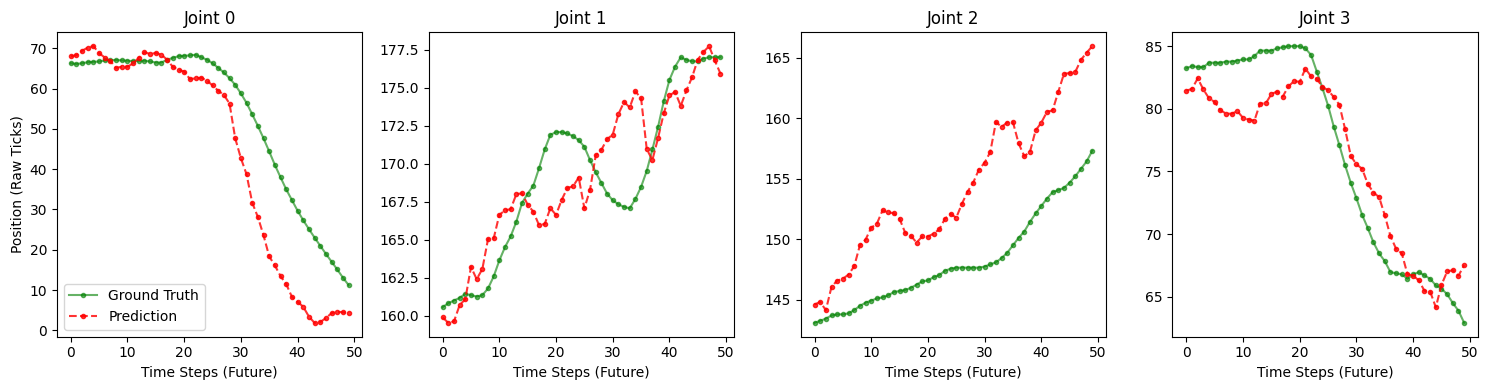

In [ ]:
# Prepare data
viz_idx = indices[0]
print(f"Visualizing sample index: {viz_idx}")
item = dataset[viz_idx]
batch = {k: v.unsqueeze(0).to(DEVICE) for k, v in item.items() if isinstance(v, torch.Tensor)}

# Important: image values should be in [0, 1]
for key in batch:
    if "image" in key:
        batch[key] = batch[key].float() / 255.0

# Tokenize text input
text_prompt = item["task"]
encoded_text = tokenizer(text_prompt, padding="max_length", max_length=48, truncation=True, return_tensors="pt")
batch["observation.language.tokens"] = encoded_text["input_ids"].to(DEVICE)
batch["observation.language.attention_mask"] = encoded_text["attention_mask"].to(DEVICE).bool()

# Normalize inputs
batch["action"] = normalize_data(batch["action"].float(), action_mean, action_std)
if "observation.state" in batch:
    batch["observation.state"] = normalize_data(batch["observation.state"].float(), state_mean, state_std)

# 2. Inference 
with torch.no_grad():
    # Output shape: [batch=1, steps=50, action_dim=6]

    pred_chunk_norm = policy.predict_action_chunk(batch)
    
    # Denormalize prediction
    pred_chunk_physical = unnormalize_data(pred_chunk_norm, action_mean, action_std).cpu().numpy().squeeze(0)
    
    # Ground truth 
    gt_chunk_physical = dataset[viz_idx]['action'].numpy()

# 3. Plot trajectories (prediction vs ground truth)
plt.figure(figsize=(15, 4))
joints_to_plot = [0, 1, 2, 3] 

for i, joint_idx in enumerate(joints_to_plot):
    ax = plt.subplot(1, 4, i+1)
    
    ax.plot(gt_chunk_physical[:, joint_idx], 'g.-', label='Ground Truth', alpha=0.6)

    ax.plot(pred_chunk_physical[:, joint_idx], 'r.--', label='Prediction', alpha=0.8)
    
    ax.set_title(f"Joint {joint_idx}")
    ax.set_xlabel("Time Steps (Future)")
    if i == 0:
        ax.set_ylabel("Position (Raw Ticks)")
        ax.legend()

plt.tight_layout()
plt.savefig("../outputs/plot_trajectories.png", bbox_inches='tight')
plt.show()